In [1]:
import numpy as np
import pandas as pd
import gc
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import random

import warnings 
warnings.filterwarnings('ignore')

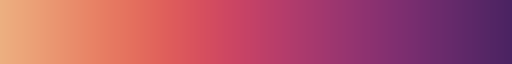

In [2]:
random.seed(42)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
sns.color_palette("flare", as_cmap=True)

# Loding Data

In [3]:
dataframe = pd.read_feather('../input/amexfeather/train_data.ftr')
dataframe = dataframe.groupby('customer_ID').tail(1).set_index('customer_ID')

# limit for testing
dataframe = dataframe.head(5000)

# Missing values

In [4]:
null_vals = dataframe.isna().sum().sort_values(ascending=False)
null_vals[null_vals > 0 ]

D_87     4994
D_88     4986
D_108    4967
D_110    4950
D_111    4950
         ... 
D_52        9
D_72        9
D_81        8
B_25        4
B_15        4
Length: 90, dtype: int64

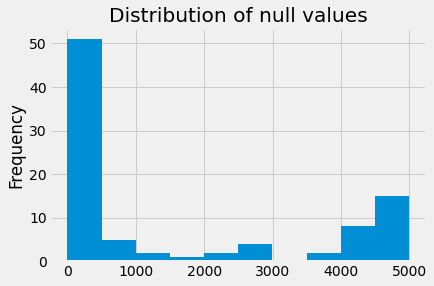

In [5]:
plt.title("Distribution of null values")
null_vals[null_vals > 0 ].plot(kind = 'hist');

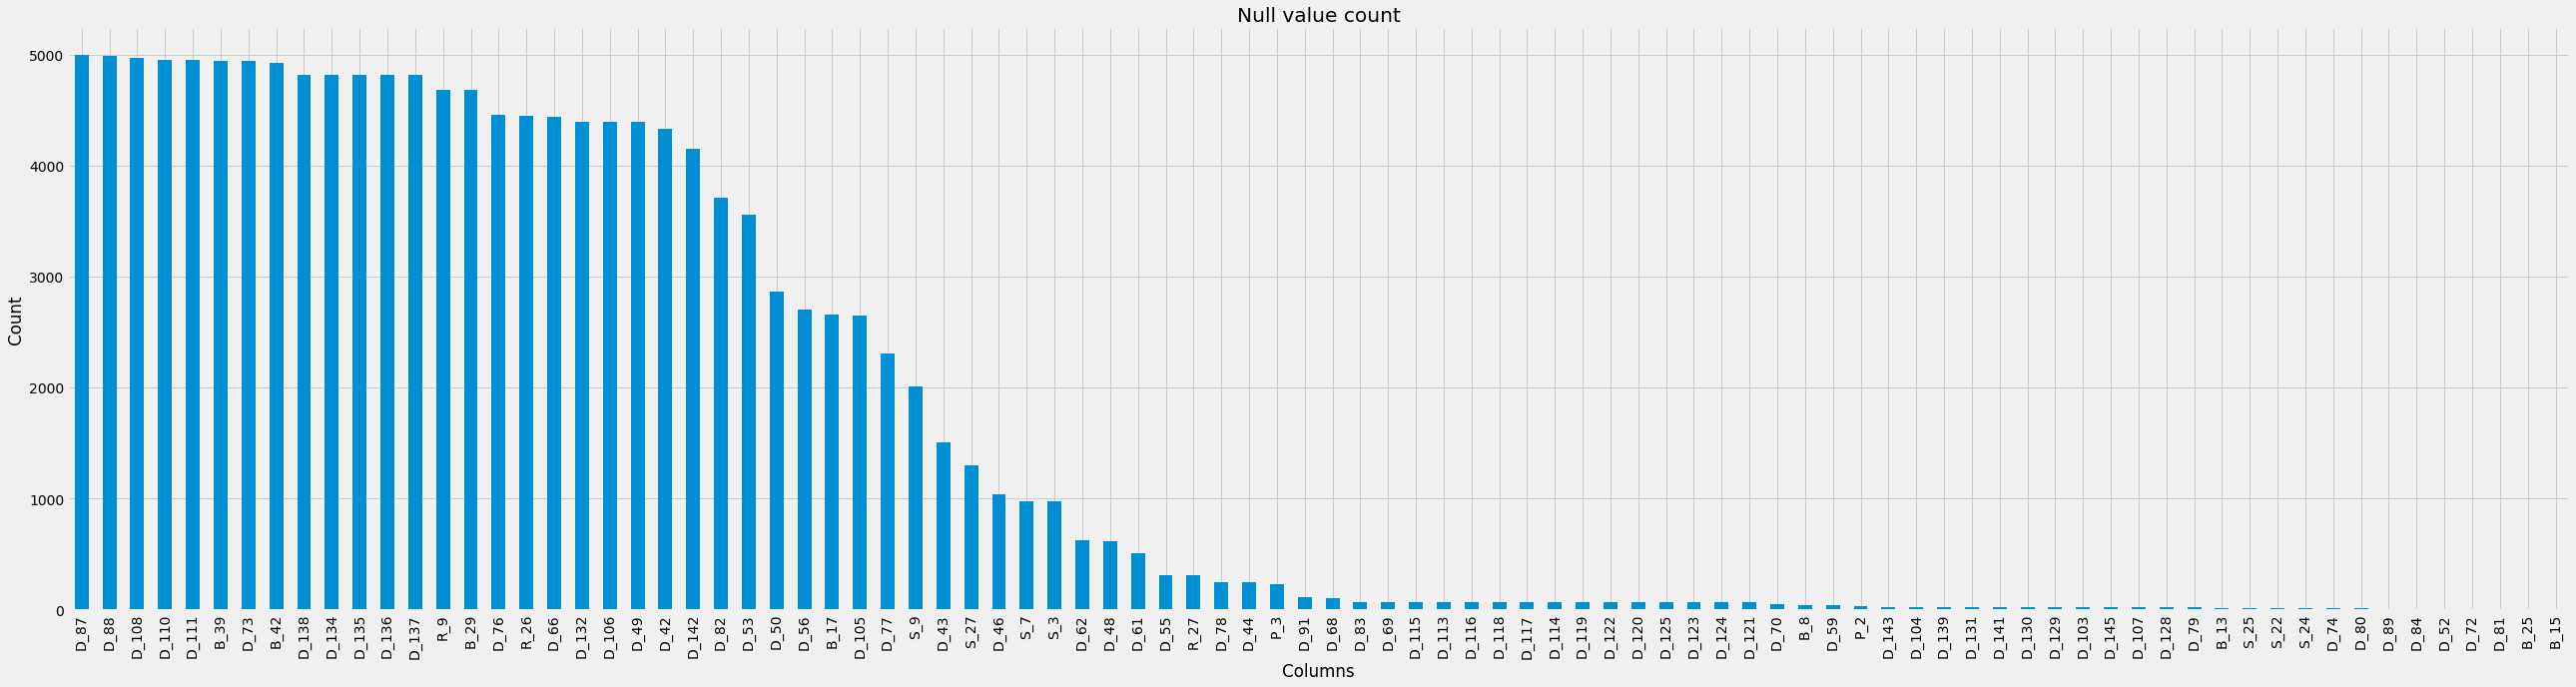

In [6]:
plt.figure(figsize=(40,10))
plt.title("Null value count")
plt.xlabel("Columns")
plt.ylabel("Count")
null_vals[null_vals > 0 ].plot(kind="bar");

# Target Imbalance

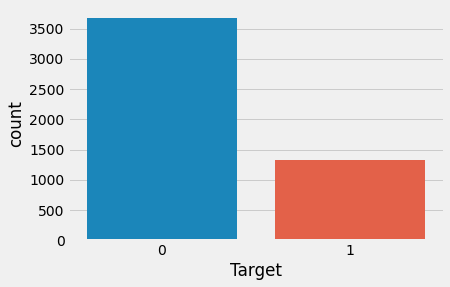

In [7]:
sns.countplot(
    dataframe["target"].values,
).set_xlabel("Target");

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers


In [9]:

#change datetime to timestamp
dataframe['S_2'] = dataframe[['S_2']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
dataframe['S_2']

customer_ID
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a    1520899200
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5    1521936000
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1    1520812800
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc    1522281600
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed    1522368000
                                                                       ...    
02cd785e3f7a04360ffa501c4ed676ceca8fc29538a1c08cae961796e5cc1f82    1521676800
02cdd7500c03bd2fb73eb0fc44bd0126ef58316f2c7021c17e83a84863672de5    1519862400
02cde14927e62232e0fa6388b31796fa17fd057da8a0b66fe8e7ea12c58886e9    1521244800
02ce0eb533f00c061e1fda9f5720e3ea97681c7fde716ebb2d5a28ab06229c66    1521676800
02ce1f612c586a0d8ace48582bdd6e20120ab530566fe84c02d61fa1be0bd3e8    1521417600
Name: S_2, Length: 5000, dtype: int64

In [10]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 4000 samples for training and 1000 for validation


In [11]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

2022-08-20 03:23:32.323416: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)


Input: {'S_2': <tf.Tensor: shape=(), dtype=int64, numpy=1521072000>, 'P_2': <tf.Tensor: shape=(), dtype=float16, numpy=0.8174>, 'D_39': <tf.Tensor: shape=(), dtype=float16, numpy=0.009995>, 'B_1': <tf.Tensor: shape=(), dtype=float16, numpy=0.3098>, 'B_2': <tf.Tensor: shape=(), dtype=float16, numpy=0.04303>, 'R_1': <tf.Tensor: shape=(), dtype=float16, numpy=0.7505>, 'S_3': <tf.Tensor: shape=(), dtype=float16, numpy=0.12244>, 'D_41': <tf.Tensor: shape=(), dtype=float16, numpy=0.003124>, 'B_3': <tf.Tensor: shape=(), dtype=float16, numpy=0.2024>, 'D_42': <tf.Tensor: shape=(), dtype=float16, numpy=nan>, 'D_43': <tf.Tensor: shape=(), dtype=float16, numpy=nan>, 'D_44': <tf.Tensor: shape=(), dtype=float16, numpy=0.004135>, 'B_4': <tf.Tensor: shape=(), dtype=float16, numpy=0.24>, 'D_45': <tf.Tensor: shape=(), dtype=float16, numpy=0.264>, 'B_5': <tf.Tensor: shape=(), dtype=float16, numpy=0.0252>, 'R_2': <tf.Tensor: shape=(), dtype=float16, numpy=0.002012>, 'D_46': <tf.Tensor: shape=(), dtype=flo

In [13]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)


In [14]:
#pip install tensorflow.keras.layers -U

In [15]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables
with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Your task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric.

In [16]:
inputs = dataframe.columns.tolist()
#del dataframe
#gc.collect()
#with the following features being categorical:

categoricals  = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']

as_string = ['D_63' ,'D_64']

exclude = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68','target']



#list of all numerical 

#apparently there is no simpler sinthax to remove list of elements from a list

numericals = [x for x in inputs if x not in exclude]



# Build a model


In [ ]:
# Categorical features encoded as integers
var_inputs_numericals = {}
var_encoded = {}
for var_num in numericals:
    var_inputs_numericals[var_num] =  keras.Input(shape=(1,), name=var_num)
    var_encoded[var_num] = encode_numerical_feature(var_inputs_numericals[var_num], var_num, train_ds)


2022-08-20 03:23:33.794002: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [ ]:
# Categorical features encoded as integers
var_inputs_categoricals = {}
for var_num in categoricals:
    var_inputs_categoricals[var_num] =  keras.Input(shape=(1,), name=var_num, dtype="int64")
    var_encoded[var_num] = encode_categorical_feature(var_inputs_categoricals[var_num], var_num, train_ds, False)

In [ ]:
# Categorical feature encoded as string
var_imput_string = {}
for var_num in as_string:
    var_imput_string[var_num] =  keras.Input(shape=(1,), name=var_num, dtype="string")
    var_encoded[var_num] = encode_categorical_feature(var_imput_string[var_num], var_num, train_ds, True)

In [ ]:
var_inputs_numericals['S_2']

In [ ]:


all_features = layers.concatenate(input_list)

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

In [ ]:
all_features

In [ ]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

In [ ]:
#inference exampple

sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

# Submissions

Fit Submission to model



In [ ]:
submit = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
submit['prediction'] = 0

for df in dfs:
    submit['prediction'] += df['prediction']
    
submit['prediction'] /= 4

submit.to_csv('mean_submission.csv', index=None)


submit = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
submit['prediction'] = 0

for df in dfs:
    submit['prediction'] += rankdata(df['prediction'])/df.shape[0]
    
submit['prediction'] /= 4

submit.to_csv('rank_submission.csv', index=None)


In [ ]:
submit

In [ ]:
submit.describe()

In [ ]:
submit.plot()

In [ ]:
weights = [0.52, 0.87, 0.95, 0.57, 1, 0.8]

In [ ]:
submit = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
submit['prediction'] = 0

for df, weight in zip(dfs, weights):
    submit['prediction'] += (df['prediction'] * weight)
    
submit['prediction'] /= np.sum(weights)

submit.to_csv('mean_submission.csv', index=None)

 
submit = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
submit['prediction'] = 0

for df, weight in zip(dfs, weights):
    submit['prediction'] += (rankdata(df['prediction'])/df.shape[0]) * weight
    
submit['prediction'] /= 4

submit.to_csv('submission.csv', index=None)    

In [ ]:
submit

In [ ]:
submit.describe()

In [ ]:
submit.plot()